In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,Callback
# from tensorflow.keras.applications import inceptionV3
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import time
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE=256
batch_size=32
Channels=3
EPOCHS=50
dataset='/content/drive/MyDrive/consolidated'
# dataset="C:/Users/panka/Downloads/archive (3)/AutismDataset/consolidated"


In [ ]:
datasets='/content/drive/MyDrive/consolidated'
# datasets="C:/Users/panka/Downloads/archive (3)/AutismDataset/consolidated"
class_names = ["ASD","Non-ASD"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'ASD': 0, 'Non-ASD': 1}

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
def load_data():
    images, labels = [], []


    for folder in os.listdir(datasets):
        label = class_name_labels[folder]

        for file in tqdm(os.listdir(os.path.join(datasets,folder))):

            img_path = os.path.join(datasets,folder,file)

            img = cv2.imread(img_path)


            images.append(img)
            labels.append(label)
            pass
        pass
    # images = np.array(images,dtype=np.float32)/255.0
    # labels = np.array(labels,dtype=np.float32)

    return (images, labels)
    pass


In [ ]:
(images,labels)=load_data()
labels[1470:1500]


  0%|          | 7/1470 [00:03<11:52,  2.05it/s]

In [ ]:
class_names

In [ ]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    datasets,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=batch_size
)

In [ ]:
class_names=datasets.class_names
class_names

In [ ]:
len(datasets)

In [ ]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in datasets.take(1):
    print(image_batch[0].numpy())# printing the ist image
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32")) # random image every time
        plt.title(class_names[label_batch[i]])# supply label name as index inside class name
        plt.axis('off')
    print("/n")
    print(image_batch.shape)
    print("/n")
    print(label_batch.numpy()) # converting every element that we are getting from tensor to numpy array.

In [ ]:
# ds-> dataset
def get_dataset_partitions_df(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds=get_dataset_partitions_df(datasets)
len(train_ds)
len(val_ds)
len(test_ds)

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # it will read the image from disk and for next iteration if we need same image it will keep that image in memory
# it will improve performance of the model

# if we are using gpu and cpu if gpu is busy training then prefetch will load the next set of batch from the disk
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
labels
labels=to_categorical(labels)
labels
len(dataset)*batch_size-4
train_images, train_labels=images[0:len(train_ds)*batch_size],labels[0:len(train_ds)*batch_size]
val_images,val_labels=images[len(train_ds)*batch_size: len(val_ds)*batch_size],labels[len(train_ds)*batch_size: len(val_ds)*batch_size]
test_images,test_labels=images[-len(val_ds)*batch_size:],labels[-len(val_ds)*batch_size:]

# **Mobilenet**

In [ ]:
img_size=(256,256,3)
def make_model(img_size):
    # print('Enter the initial model learning rate. I recommend .002', flush=True)
    # lr=float(input(' '))
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.mobilenet.MobileNet(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=True


    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.45, seed=123)(x)
    # x=Dense(64, activation='relu')(x)
    # z=Dropout(0.2)
    output=Dense(2, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_mobilenet=make_model(img_size)

In [ ]:
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 128, 128, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 128, 128, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 128, 128, 32)      128   

In [ ]:
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
Precision=Precision()
Recall=Recall()
AUC=AUC()
accuracy=Accuracy()
model_mobilenet.compile(Adam(learning_rate=0.0003),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# model.compile(Adam(learning_rate=0.0003),
#     loss=keras.losses.categorical_crossentropy,
#     metrics=['a']
# )

In [ ]:
# from tensorflow import keras
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

# # Create instances of metrics with different names
# precision_metric = Precision()
# recall_metric = Recall()
# auc_metric = AUC()
# accuracy_metric = Accuracy()

# model.compile(
#     optimizer=Adam(learning_rate=0.0003),
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=[accuracy_metric, auc_metric, precision_metric, recall_metric]
# )


In [ ]:
history_1 = model_mobilenet.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
74/74 [==============================] - 63s 455ms/step - loss: 7.0380 - accuracy: 0.7020 - val_loss: 6.8334 - val_accuracy: 0.6215
Epoch 2/50
74/74 [==============================] - 12s 158ms/step - loss: 5.0573 - accuracy: 0.8707 - val_loss: 5.9275 - val_accuracy: 0.5486
Epoch 3/50
74/74 [==============================] - 11s 142ms/step - loss: 3.7319 - accuracy: 0.9494 - val_loss: 3.4257 - val_accuracy: 0.8681
Epoch 4/50
74/74 [==============================] - 10s 142ms/step - loss: 2.7760 - accuracy: 0.9860 - val_loss: 2.5055 - val_accuracy: 0.9514
Epoch 5/50
74/74 [==============================] - 11s 144ms/step - loss: 2.0803 - accuracy: 0.9983 - val_loss: 1.9167 - val_accuracy: 0.9375
Epoch 6/50
74/74 [==============================] - 11s 145ms/step - loss: 1.5618 - accuracy: 1.0000 - val_loss: 1.4500 - val_accuracy: 0.9514
Epoch 7/50
74/74 [==============================] - 11s 148ms/step - loss: 1.1787 - accuracy: 0.9996 - val_loss: 1.1240 - val_accuracy: 0.9514

In [ ]:
file_path='/content/drive/MyDrive/Autism_classification/Autism h5 file/mobilnet.h5'
model_mobilenet.save(file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_labels = np.concatenate([labels for images,labels in val_ds], axis=0)
val_labels

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0], dtype=int32)

In [ ]:
val_predict=model_mobilenet.predict(val_ds)
val_pred=np.argmax(val_predict, axis=1)
val_pred.shape
val_pred

9/9 [==============================] - 1s 57ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0])

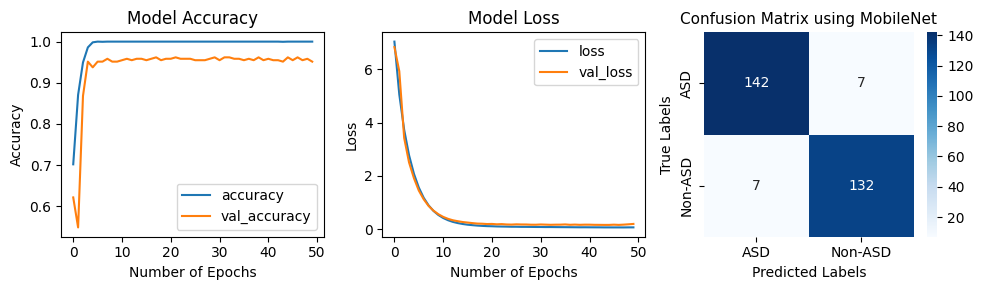

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have defined `history_1`, `val_labels`, and `val_pred`

plt.figure(figsize=(10, 3))  # Adjust the figure size as needed

# Subplot 1: Model Accuracy
plt.subplot(1, 3, 1)
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy",)
plt.legend(loc='lower right')

# Subplot 2: Model Loss
plt.subplot(1, 3, 2)
plt.plot(history_1.history['loss'], label='loss')
plt.plot(history_1.history['val_loss'], label='val_loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Model Loss",)
plt.legend(loc='upper right')

# Subplot 3: Confusion Matrix
plt.subplot(1, 3, 3)
confusion_mtx = confusion_matrix(val_labels, val_pred)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")

# Define class labels
class_labels = ['ASD', 'Non-ASD']

# Center the labels in the middle of the cells
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix using MobileNet", fontsize=11)

plt.tight_layout()
plt.show()

# plt.xticks(tick_marks, class_labels)
# plt.yticks(tick_marks, class_labels)


In [ ]:
# plt.figure(figsize=(10,4))
# plt.subplot(1, 3, 1)
# plt.plot(history_1.history['accuracy'], label='accuracy')
# plt.plot(history_1.history['val_accuracy'], label='val_accuracy')
# plt.xlabel("Number of Epochs")
# plt.ylabel("Accuracy")
# plt.title("Model Accuracy")
# plt.legend(loc='lower right')

# plt.subplot(1, 3, 2)
# plt.plot(history_1.history['loss'], label='loss')
# plt.plot(history_1.history['val_loss'], label='val_loss')
# plt.xlabel("Number of Epochs")
# plt.ylabel("Loss")
# plt.title("Model Loss")
# plt.legend(loc='lower left')
# import seaborn as sns
# confusion_mtx = confusion_matrix(val_labels, val_pred)

# # visualize confusion matrix with matplotlib and seaborn
# plt.subplot(1,3,3)
# fig, ax = plt.subplots(figsize=(3,3))
# plt= sns.heatmap(confusion_mtx, annot=True, fmt="d", ax=ax, cmap="Blues")
# plt.set_xlabel("Predicted Labels")
# plt.set_ylabel("True Label")
# # ax.set_title("Confusion Matrix using MobileNet",fontsize=10)
# # ax.xaxis.set_ticklabels(['ASD', 'Non-ASD'], fontsize=10)
# # ax.yaxis.set_ticklabels(['ASD', 'Non-ASD'],fontsize=10)
# # plt.tight_layout()
# # plt.show()

In [ ]:
print(confusion_matrix(val_labels,val_pred))
print(classification_report(val_labels, val_pred,target_names=class_names, digits= 4))

[[142   7]
 [  7 132]]
              precision    recall  f1-score   support

         ASD     0.9530    0.9530    0.9530       149
     Non-ASD     0.9496    0.9496    0.9496       139

    accuracy                         0.9514       288
   macro avg     0.9513    0.9513    0.9513       288
weighted avg     0.9514    0.9514    0.9514       288



In [ ]:
scores_mobilenet=model_mobilenet.evaluate(test_ds)

10/10 [==============================] - 22s 61ms/step - loss: 0.1417 - accuracy: 0.9750


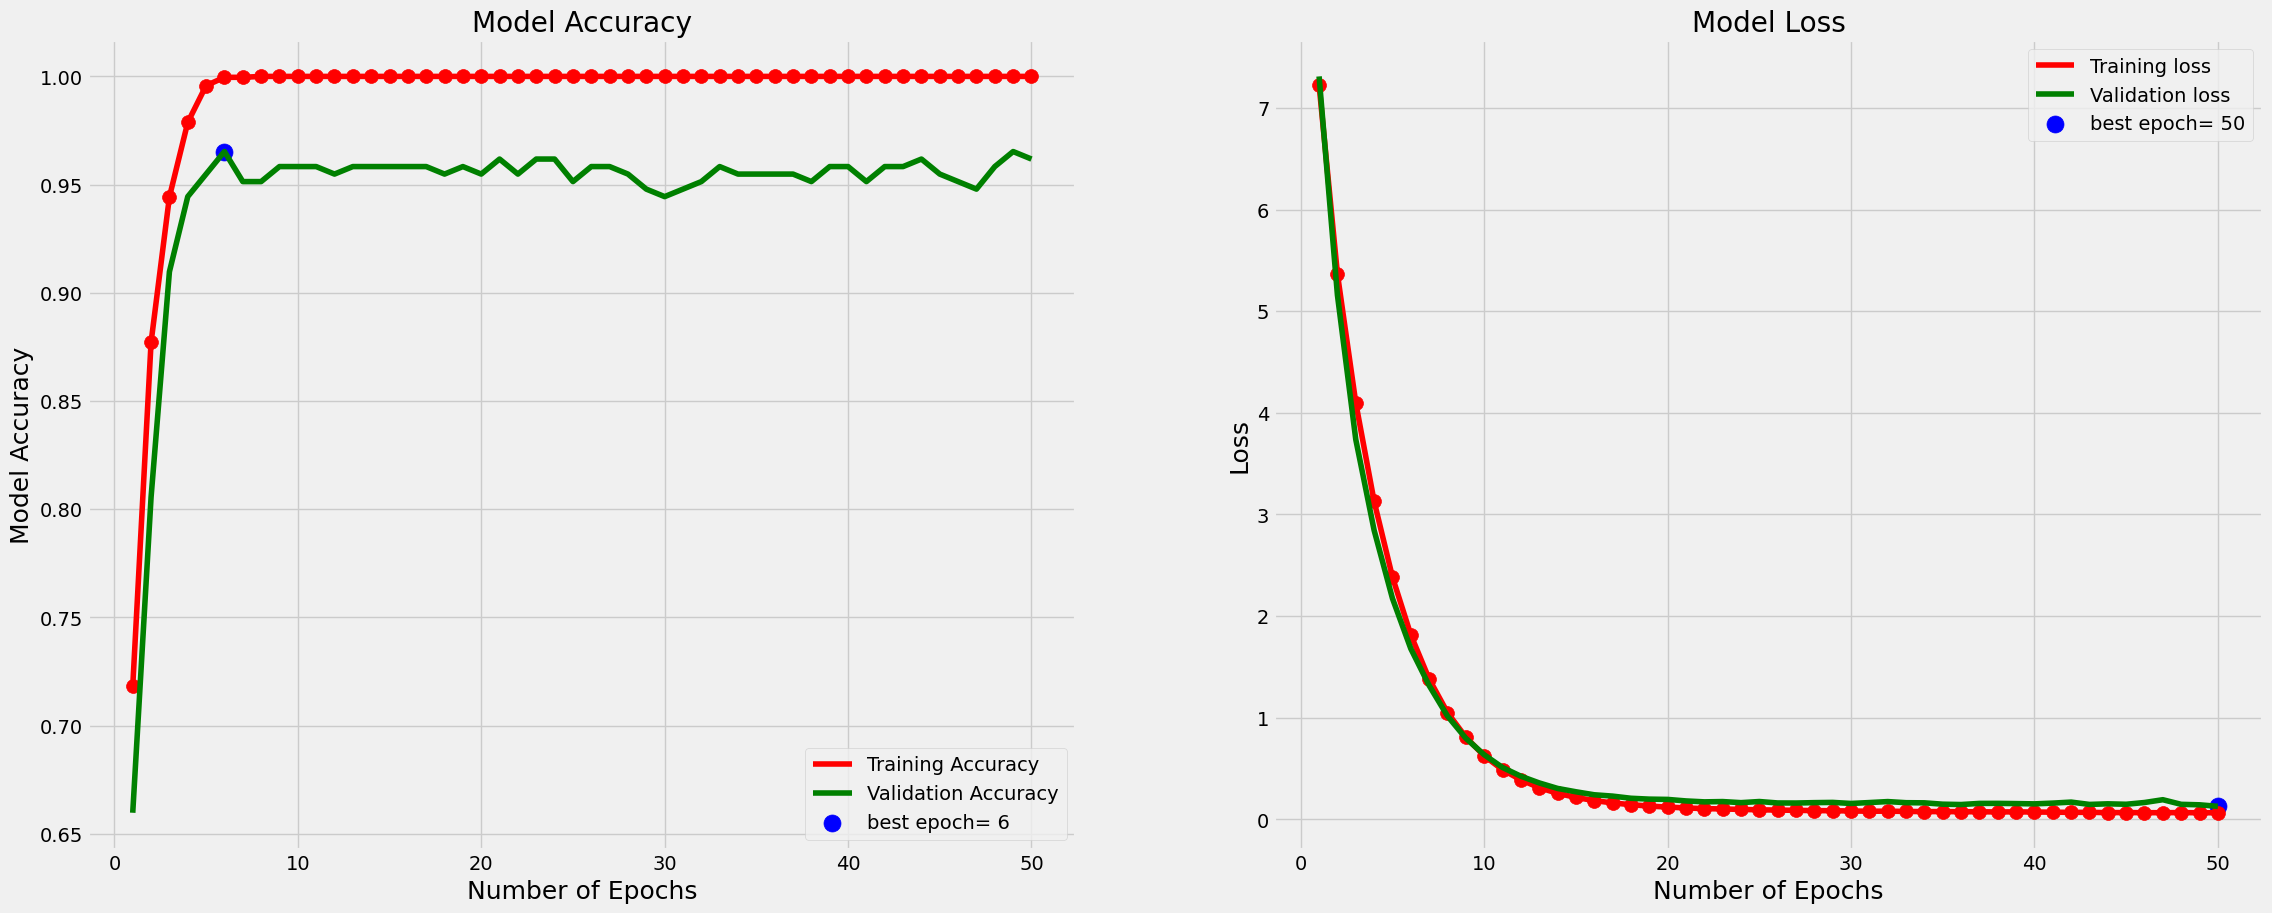

In [ ]:
import numpy as np
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[1].plot(Epochs,tloss, 'r', label='Training loss')
    axes[1].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[1].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[1].scatter(Epochs, tloss, s=100, c='red')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Number of Epochs', fontsize=18)
    axes[1].set_ylabel('Loss', fontsize=18)
    axes[1].legend()
    axes[0].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[0].scatter(Epochs, tacc, s=100, c='red')
    axes[0].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[0].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Number of Epochs', fontsize=18)
    axes[0].set_ylabel('Model Accuracy', fontsize=18)
    axes[0].legend()
    plt.tight_layout
    plt.show()
    return index_loss

loss_index=tr_plot(history,0)

In [ ]:
scores_mobilenet=model_mobilenet.evaluate(test_ds)

10/10 [==============================] - 13s 55ms/step - loss: 0.1332 - accuracy: 0.9750


In [ ]:


def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



1/1 [==============================] - 0s 20ms/step


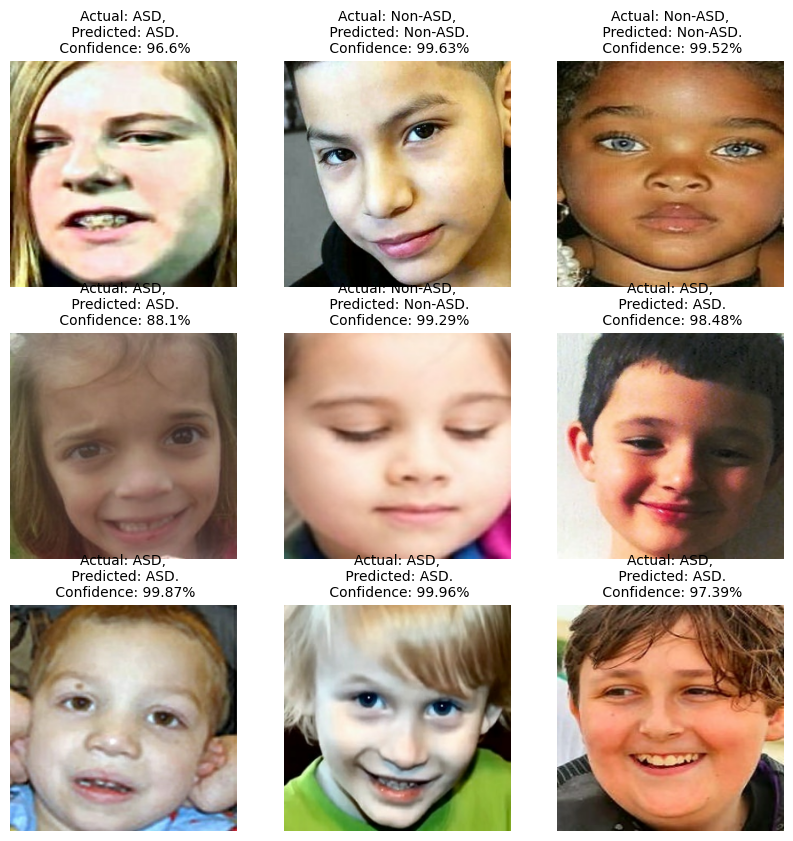

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))


        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%",fontsize=10)

        plt.axis("off")

# **Resnet50**

In [ ]:
img_size=(256,256,3)
def make_model(img_size):
    print('Enter the initial model learning rate. I recommend .002', flush=True)
    lr=float(input(' '))
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=False
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    # x=Dense(64, activation='relu')(x)
    # z=Dropout(0.2)
    output=Dense(2, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_resnet=make_model(img_size)

Enter the initial model learning rate. I recommend .002
 999
94765736/94765736 [==============================] - 17s 0us/step


In [ ]:
model_resnet.compile(
    optimizer=Adam(learning_rate=0.00015),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history_2 = model_resnet.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
74/74 [==============================] - 20s 171ms/step - loss: 8.2708 - accuracy: 0.6913 - val_loss: 7.8031 - val_accuracy: 0.8125
Epoch 2/50
74/74 [==============================] - 10s 133ms/step - loss: 6.9831 - accuracy: 0.8002 - val_loss: 6.4924 - val_accuracy: 0.8681
Epoch 3/50
74/74 [==============================] - 10s 133ms/step - loss: 6.0087 - accuracy: 0.8563 - val_loss: 5.5841 - val_accuracy: 0.8958
Epoch 4/50
74/74 [==============================] - 10s 139ms/step - loss: 5.2066 - accuracy: 0.8920 - val_loss: 4.8501 - val_accuracy: 0.9271
Epoch 5/50
74/74 [==============================] - 10s 131ms/step - loss: 4.5112 - accuracy: 0.9298 - val_loss: 4.2437 - val_accuracy: 0.9271
Epoch 6/50
74/74 [==============================] - 10s 129ms/step - loss: 3.9537 - accuracy: 0.9413 - val_loss: 3.7294 - val_accuracy: 0.9340
Epoch 7/50
74/74 [==============================] - 10s 132ms/step - loss: 3.4458 - accuracy: 0.9643 - val_loss: 3.2792 - val_accuracy: 0.9444

In [ ]:
file_path='/content/drive/MyDrive/Autism_classification/Autism h5 file/resnet.h5'
model_resnet.save(file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_labels = np.concatenate([labels for images,labels in val_ds], axis=0)
print(val_labels)

val_predict=model_resnet.predict(val_ds)
val_pred=np.argmax(val_predict, axis=1)
val_pred.shape
val_pred



[0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0
 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1
 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0
 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0]
9/9 [==============================] - 2s 116ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0])

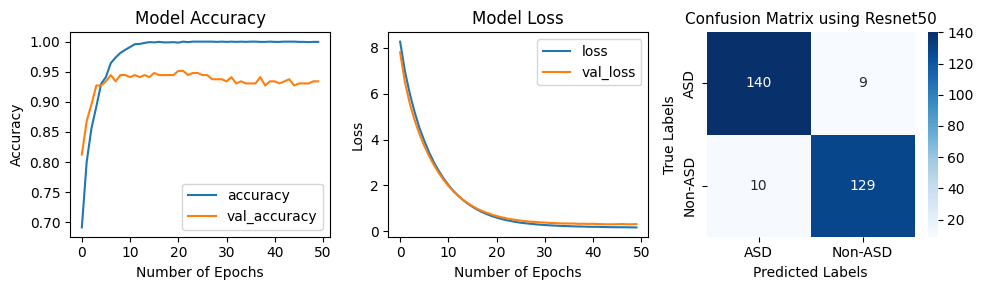

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have defined `history_1`, `val_labels`, and `val_pred`

plt.figure(figsize=(10, 3))  # Adjust the figure size as needed

# Subplot 1: Model Accuracy
plt.subplot(1, 3, 1)
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy",)
plt.legend(loc='lower right')

# Subplot 2: Model Loss
plt.subplot(1, 3, 2)
plt.plot(history_2.history['loss'], label='loss')
plt.plot(history_2.history['val_loss'], label='val_loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Model Loss",)
plt.legend(loc='upper right')

# Subplot 3: Confusion Matrix
plt.subplot(1, 3, 3)
confusion_mtx = confusion_matrix(val_labels, val_pred)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")

# Define class labels
class_labels = ['ASD', 'Non-ASD']

# Center the labels in the middle of the cells
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix using Resnet50", fontsize=11)

plt.tight_layout()

plt.show()

# plt.xticks(tick_marks, class_labels)
# plt.yticks(tick_marks, class_labels)


In [ ]:
print(confusion_matrix(val_labels,val_pred))
print(classification_report(val_labels, val_pred,target_names=class_names, digits= 4))


scores_resnet=model_resnet.evaluate(test_ds)

[[140   9]
 [ 10 129]]
              precision    recall  f1-score   support

         ASD     0.9333    0.9396    0.9365       149
     Non-ASD     0.9348    0.9281    0.9314       139

    accuracy                         0.9340       288
   macro avg     0.9341    0.9338    0.9339       288
weighted avg     0.9340    0.9340    0.9340       288

10/10 [==============================] - 1s 119ms/step - loss: 0.2537 - accuracy: 0.9656


# **Xception**

In [ ]:
img_size=(256,256,3)
def make_model(img_size):
    print('Enter the initial model learning rate. I recommend .002', flush=True)
    lr=float(input(' '))
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=False
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    # x=Dense(64, activation='relu')(x)
    # z=Dropout(0.2)
    output=Dense(2, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_xception=make_model(img_size)

Enter the initial model learning rate. I recommend .002
 0.002


In [ ]:
model_xception.compile(
    optimizer=Adam(learning_rate=0.00015),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

history_3 = model_xception.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
74/74 [==============================] - 47s 322ms/step - loss: 7.7302 - accuracy: 0.6101 - val_loss: 7.0094 - val_accuracy: 0.6771
Epoch 2/50
74/74 [==============================] - 13s 175ms/step - loss: 6.0687 - accuracy: 0.6896 - val_loss: 5.4667 - val_accuracy: 0.7535
Epoch 3/50
74/74 [==============================] - 14s 187ms/step - loss: 4.9424 - accuracy: 0.7683 - val_loss: 4.5066 - val_accuracy: 0.7674
Epoch 4/50
74/74 [==============================] - 14s 187ms/step - loss: 4.1605 - accuracy: 0.8112 - val_loss: 3.8386 - val_accuracy: 0.8056
Epoch 5/50
74/74 [==============================] - 13s 169ms/step - loss: 3.5612 - accuracy: 0.8265 - val_loss: 3.3438 - val_accuracy: 0.8194
Epoch 6/50
74/74 [==============================] - 13s 172ms/step - loss: 3.0938 - accuracy: 0.8622 - val_loss: 2.9363 - val_accuracy: 0.8160
Epoch 7/50
74/74 [==============================] - 13s 172ms/step - loss: 2.7215 - accuracy: 0.8822 - val_loss: 2.5994 - val_accuracy: 0.8542

In [ ]:
file_path='/content/drive/MyDrive/Autism_classification/Autism h5 file/xception.h5'
model_xception.save(file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_labels = np.concatenate([labels for images,labels in val_ds], axis=0)
print(val_labels)

val_predict=model_xception.predict(val_ds)
val_pred=np.argmax(val_predict, axis=1)
val_pred.shape
val_pred


[0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0
 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1
 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0
 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0]
9/9 [==============================] - 3s 152ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0])

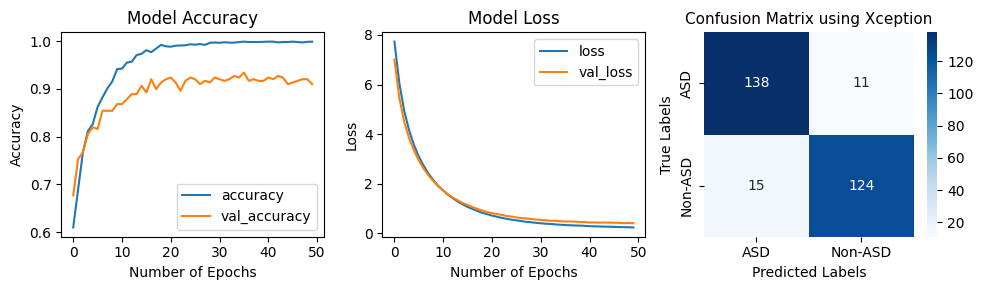

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have defined `history_1`, `val_labels`, and `val_pred`

plt.figure(figsize=(10, 3))  # Adjust the figure size as needed

# Subplot 1: Model Accuracy
plt.subplot(1, 3, 1)
plt.plot(history_3.history['accuracy'], label='accuracy')
plt.plot(history_3.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy",)
plt.legend(loc='lower right')

# Subplot 2: Model Loss
plt.subplot(1, 3, 2)
plt.plot(history_3.history['loss'], label='loss')
plt.plot(history_3.history['val_loss'], label='val_loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Model Loss",)
plt.legend(loc='upper right')

# Subplot 3: Confusion Matrix
plt.subplot(1, 3, 3)
confusion_mtx = confusion_matrix(val_labels, val_pred)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")

# Define class labels
class_labels = ['ASD', 'Non-ASD']

# Center the labels in the middle of the cells
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix using Xception", fontsize=11)

plt.tight_layout()

plt.show()

# plt.xticks(tick_marks, class_labels)
# plt.yticks(tick_marks, class_labels)


In [ ]:
print(confusion_matrix(val_labels,val_pred))
print(classification_report(val_labels, val_pred,target_names=class_names, digits= 4))


scores_xception=model_xception.evaluate(test_ds)

[[138  11]
 [ 15 124]]
              precision    recall  f1-score   support

         ASD     0.9020    0.9262    0.9139       149
     Non-ASD     0.9185    0.8921    0.9051       139

    accuracy                         0.9097       288
   macro avg     0.9102    0.9091    0.9095       288
weighted avg     0.9100    0.9097    0.9097       288

10/10 [==============================] - 10s 150ms/step - loss: 0.3994 - accuracy: 0.9156


# **DenseNet**

In [ ]:
img_size=(256,256,3)
def make_model(img_size):
    print('Enter the initial model learning rate. I recommend .002', flush=True)
    lr=float(input(' '))
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.densenet.DenseNet169(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=False


    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.45, seed=123)(x)
    x=Dense(128, activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(64, activation='relu')(x)
    x=Dropout(0.2)(x)
    output=Dense(2, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision','recall'])
    return model

model_densenet=make_model(img_size)

Enter the initial model learning rate. I recommend .002
 0.002
51877672/51877672 [==============================] - 2s 0us/step


In [ ]:
model_densenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 262, 262, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
model_densenet.compile(
    optimizer=Adam(learning_rate=0.00015),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

history_4 = model_densenet.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
74/74 [==============================] - 35s 239ms/step - loss: 7.6404 - accuracy: 0.5838 - val_loss: 7.0559 - val_accuracy: 0.6389
Epoch 2/50
74/74 [==============================] - 12s 157ms/step - loss: 6.2325 - accuracy: 0.6526 - val_loss: 5.7037 - val_accuracy: 0.6944
Epoch 3/50
74/74 [==============================] - 12s 156ms/step - loss: 5.2781 - accuracy: 0.6730 - val_loss: 4.8492 - val_accuracy: 0.7326
Epoch 4/50
74/74 [==============================] - 11s 154ms/step - loss: 4.5586 - accuracy: 0.7079 - val_loss: 4.2285 - val_accuracy: 0.7778
Epoch 5/50
74/74 [==============================] - 11s 155ms/step - loss: 3.9959 - accuracy: 0.7398 - val_loss: 3.7416 - val_accuracy: 0.7708
Epoch 6/50
74/74 [==============================] - 11s 153ms/step - loss: 3.5593 - accuracy: 0.7628 - val_loss: 3.3443 - val_accuracy: 0.7986
Epoch 7/50
74/74 [==============================] - 11s 155ms/step - loss: 3.1950 - accuracy: 0.7874 - val_loss: 3.0036 - val_accuracy: 0.8333

In [ ]:
file_path='/content/drive/MyDrive/Autism_classification/Autism h5 file/densenet.h5'
model_densenet.save(file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_labels = np.concatenate([labels for images,labels in val_ds], axis=0)
print(val_labels)

val_predict=model_densenet.predict(val_ds)
val_pred=np.argmax(val_predict, axis=1)
val_pred.shape
val_pred


[0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0
 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1
 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0
 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0]
9/9 [==============================] - 5s 137ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0])

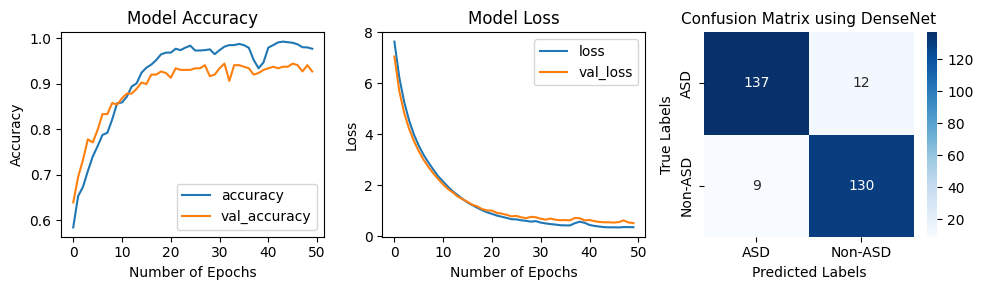

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have defined `history_1`, `val_labels`, and `val_pred`

plt.figure(figsize=(10, 3))  # Adjust the figure size as needed

# Subplot 1: Model Accuracy
plt.subplot(1, 3, 1)
plt.plot(history_4.history['accuracy'], label='accuracy')
plt.plot(history_4.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy",)
plt.legend(loc='lower right')

# Subplot 2: Model Loss
plt.subplot(1, 3, 2)
plt.plot(history_4.history['loss'], label='loss')
plt.plot(history_4.history['val_loss'], label='val_loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Model Loss",)
plt.legend(loc='upper right')

# Subplot 3: Confusion Matrix
plt.subplot(1, 3, 3)
confusion_mtx = confusion_matrix(val_labels, val_pred)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")

# Define class labels
class_labels = ['ASD', 'Non-ASD']

# Center the labels in the middle of the cells
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix using DenseNet", fontsize=11)

plt.tight_layout()

plt.show()

# plt.xticks(tick_marks, class_labels)
# plt.yticks(tick_marks, class_labels)


In [ ]:
print(confusion_matrix(val_labels,val_pred))
print(classification_report(val_labels, val_pred,target_names=class_names, digits= 4))


scores_xception=model_xception.evaluate(test_ds)

[[137  12]
 [  9 130]]
              precision    recall  f1-score   support

         ASD     0.9384    0.9195    0.9288       149
     Non-ASD     0.9155    0.9353    0.9253       139

    accuracy                         0.9271       288
   macro avg     0.9269    0.9274    0.9270       288
weighted avg     0.9273    0.9271    0.9271       288

10/10 [==============================] - 2s 152ms/step - loss: 0.3878 - accuracy: 0.9187


# **EfficienetNetB3**

In [ ]:
img_size=(256,256,3)
def make_model(img_size):
    print('Enter the initial model learning rate. I recommend .002', flush=True)
    lr=float(input(' '))
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(2, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_eff=make_model(img_size)

Enter the initial model learning rate. I recommend .002
 0.002


In [ ]:
model_eff.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][0]'] 

In [ ]:
model_eff.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

history_5 = model_eff.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
74/74 [==============================] - 132s 717ms/step - loss: 7.9127 - accuracy: 0.6773 - val_loss: 7.9425 - val_accuracy: 0.6076
Epoch 2/50
74/74 [==============================] - 48s 644ms/step - loss: 6.1673 - accuracy: 0.8776 - val_loss: 5.7534 - val_accuracy: 0.8403
Epoch 3/50
74/74 [==============================] - 48s 646ms/step - loss: 4.9712 - accuracy: 0.9392 - val_loss: 4.6923 - val_accuracy: 0.8993
Epoch 4/50
74/74 [==============================] - 48s 645ms/step - loss: 4.0082 - accuracy: 0.9702 - val_loss: 3.7636 - val_accuracy: 0.9375
Epoch 5/50
74/74 [==============================] - 48s 645ms/step - loss: 3.2427 - accuracy: 0.9779 - val_loss: 3.0793 - val_accuracy: 0.9340
Epoch 6/50
74/74 [==============================] - 48s 645ms/step - loss: 2.6489 - accuracy: 0.9834 - val_loss: 2.5193 - val_accuracy: 0.9410
Epoch 7/50
74/74 [==============================] - 48s 644ms/step - loss: 2.1952 - accuracy: 0.9902 - val_loss: 2.0792 - val_accuracy: 0.944

In [ ]:
file_path='/content/drive/MyDrive/Autism_classification/Autism h5 file/efficienetB3.h5'
model_eff.save(file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_labels = np.concatenate([labels for images,labels in val_ds], axis=0)
print(val_labels)

val_predict=model_eff.predict(val_ds)
val_pred=np.argmax(val_predict, axis=1)
val_pred.shape
val_pred


[0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0
 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1
 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0
 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0]
9/9 [==============================] - 4s 140ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0])

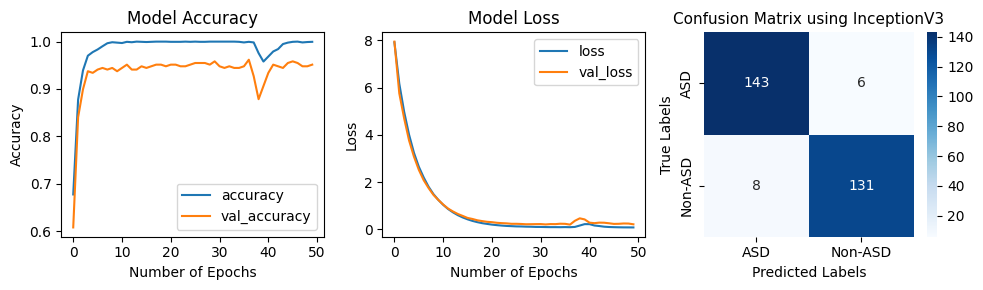

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have defined `history_1`, `val_labels`, and `val_pred`

plt.figure(figsize=(10, 3))  # Adjust the figure size as needed

# Subplot 1: Model Accuracy
plt.subplot(1, 3, 1)
plt.plot(history_5.history['accuracy'], label='accuracy')
plt.plot(history_5.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy",)
plt.legend(loc='lower right')

# Subplot 2: Model Loss
plt.subplot(1, 3, 2)
plt.plot(history_5.history['loss'], label='loss')
plt.plot(history_5.history['val_loss'], label='val_loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Model Loss",)
plt.legend(loc='upper right')

# Subplot 3: Confusion Matrix
plt.subplot(1, 3, 3)
confusion_mtx = confusion_matrix(val_labels, val_pred)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")

# Define class labels
class_labels = ['ASD', 'Non-ASD']

# Center the labels in the middle of the cells
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix using InceptionV3", fontsize=11)

plt.tight_layout()

plt.show()

# plt.xticks(tick_marks, class_labels)
# plt.yticks(tick_marks, class_labels)


In [ ]:
print(confusion_matrix(val_labels,val_pred))
print(classification_report(val_labels, val_pred,target_names=class_names, digits= 4))


scores_efficientNetB3=model_eff.evaluate(test_ds)

[[143   6]
 [  8 131]]
              precision    recall  f1-score   support

         ASD     0.9470    0.9597    0.9533       149
     Non-ASD     0.9562    0.9424    0.9493       139

    accuracy                         0.9514       288
   macro avg     0.9516    0.9511    0.9513       288
weighted avg     0.9515    0.9514    0.9514       288

10/10 [==============================] - 1s 144ms/step - loss: 0.1024 - accuracy: 0.9906


#**Inception_V3**

In [ ]:
img_size=(256,256,3)
def make_model(img_size):
    print('Enter the initial model learning rate. I recommend .002', flush=True)
    # lr=float(input(' '))
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=True


    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.6,seed=123)(x)
    # x=Dense(128, activation='relu')(x)
    # x=BatchNormalization()(x)
    # x=Dropout(0.4)(x)
    # x=Dense(128, activation='relu')(x)
    # x=BatchNormalization()(x)
    # x=Dropout(0.4)(x)
    output=Dense(2, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_inception=make_model(img_size)

Enter the initial model learning rate. I recommend .002
87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
model_inception.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 127, 127, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 127, 127, 32)         96        ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization_6[

In [ ]:
model_inception.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

history_6 = model_inception.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
74/74 [==============================] - 75s 387ms/step - loss: 8.2757 - accuracy: 0.6773 - val_loss: 8.3917 - val_accuracy: 0.6840
Epoch 2/50
74/74 [==============================] - 23s 308ms/step - loss: 6.5785 - accuracy: 0.8099 - val_loss: 7.5519 - val_accuracy: 0.8090
Epoch 3/50
74/74 [==============================] - 23s 312ms/step - loss: 5.2278 - accuracy: 0.9133 - val_loss: 5.2494 - val_accuracy: 0.8438
Epoch 4/50
74/74 [==============================] - 23s 313ms/step - loss: 4.2629 - accuracy: 0.9813 - val_loss: 4.0053 - val_accuracy: 0.9410
Epoch 5/50
74/74 [==============================] - 23s 309ms/step - loss: 3.5025 - accuracy: 0.9991 - val_loss: 3.3065 - val_accuracy: 0.9444
Epoch 6/50
74/74 [==============================] - 23s 306ms/step - loss: 2.9061 - accuracy: 1.0000 - val_loss: 2.7532 - val_accuracy: 0.9444
Epoch 7/50
74/74 [==============================] - 23s 315ms/step - loss: 2.4177 - accuracy: 0.9996 - val_loss: 2.3005 - val_accuracy: 0.9444

In [ ]:
file_path='/content/drive/MyDrive/Autism_classification/Autism h5 file/InceptionV3.h5'
model_inception.save(file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_labels = np.concatenate([labels for images,labels in val_ds], axis=0)
print(val_labels)

val_predict=model_inception.predict(val_ds)
val_pred=np.argmax(val_predict, axis=1)
val_pred.shape
val_pred


[0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0
 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1
 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0
 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0]
9/9 [==============================] - 2s 90ms/step


array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0])

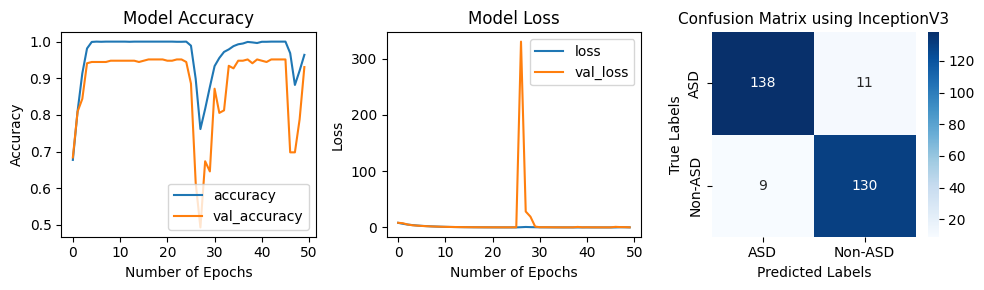

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have defined `history_1`, `val_labels`, and `val_pred`

plt.figure(figsize=(10, 3))  # Adjust the figure size as needed

# Subplot 1: Model Accuracy
plt.subplot(1, 3, 1)
plt.plot(history_6.history['accuracy'], label='accuracy')
plt.plot(history_6.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy",)
plt.legend(loc='lower right')

# Subplot 2: Model Loss
plt.subplot(1, 3, 2)
plt.plot(history_6.history['loss'], label='loss')
plt.plot(history_6.history['val_loss'], label='val_loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Model Loss",)
plt.legend(loc='upper right')

# Subplot 3: Confusion Matrix
plt.subplot(1, 3, 3)
confusion_mtx = confusion_matrix(val_labels, val_pred)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")

# Define class labels
class_labels = ['ASD', 'Non-ASD']

# Center the labels in the middle of the cells
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix using InceptionV3", fontsize=11)

plt.tight_layout()

plt.show()

# plt.xticks(tick_marks, class_labels)
# plt.yticks(tick_marks, class_labels)


In [ ]:
print(confusion_matrix(val_labels,val_pred))
print(classification_report(val_labels, val_pred,target_names=class_names, digits= 4))


scores_inceptionV3=model_inception.evaluate(test_ds)

[[138  11]
 [  9 130]]
              precision    recall  f1-score   support

         ASD     0.9388    0.9262    0.9324       149
     Non-ASD     0.9220    0.9353    0.9286       139

    accuracy                         0.9306       288
   macro avg     0.9304    0.9307    0.9305       288
weighted avg     0.9307    0.9306    0.9306       288

10/10 [==============================] - 1s 88ms/step - loss: 0.2126 - accuracy: 0.9563


# **VGG_16**